In [259]:
from selenium import webdriver as wd
import urllib

In [260]:
driver = wd.Chrome('../tool/chromedriver75.0.3770.140.exe')

In [261]:
target_url = 'http://www.opinet.co.kr/searRgSelect.do'

In [262]:
#해당사이트가 중간 페이지를 직접 접속하는  부분을 거부하기 때문에
# 시간차를 
import time 
for n in range(2):
    driver.get( target_url)
    time.sleep(5)

- 1. 시도 정보를 추출하여 리스트화
- 2. 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
- 3. 시군구 리스트를 반복하면서 읍면동 리스트화
- 4. 읍면동 리스트를 반복하면서 -> 조회 -> 다운로드 순으로 진행되는 것이 기본
- 5. 사이트 관찰결과, 시도, 시군구, 읍면동, 정보가 새로 세팅되면 화면의 DOM이 모두 새로구성이 되는 문제가 있어서 반복문 안에서는 반드시 시도, 시군구, 읍면동을 새로 잡아줘야한다!!!(매우중요) 
- 6. 시군구를 반복하면서 바로 조회 및 다운로드로 전개하겠다(여기서는)

In [263]:
# 시/도 리스트 획득 구간
# 1. 구간
sidos = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIDO_NM0 > option')
        if option.get_attribute('value')
        ]
# 데이터의 상위값과, 하위값 조사를 통해 샘플링으로 확인
sidos[:2], sidos[-2:], sidos[1:2]

(['서울특별시', '부산광역시'], ['경상남도', '제주특별자치도'], ['부산광역시'])

In [264]:
# 2. 시도 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
# sidos중에 부산만 대상으로 수집하겠다
# 시퀀서: 연속데이터 자료
for sido in sidos[1:2]:
    # 2-1. sido 대상 찾아서
    sido_tag = driver.find_element_by_id('SIDO_NM0') # sido변수명이 겹쳐서 tag를 찾는 sido라 하여 sido_tag라한다
    # 2-2. sido 값을 설정
    sido_tag.send_keys( sido ) # 값을 설정하는 코드임, ajax를 통해서 서버를 연결해준다
    # 2-2-2. 잠시대기( ajax 통신후 화면이 재구성될때까지 )
    time.sleep(6)
    # 2-3. 시군구 리스트 획득
    sigungus = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIGUNGU_NM0 > option')
        if option.get_attribute('value')
    ] 
    print( sido, sigungus[:2])    
    # 2-4. 반복~, 3단계로 진입
    # 3. 시군구 리스트를 반복하면서 -> 조회(대기시간이 필요하다(대기시간 설정:5초정도)) -> 엑셀저장
    for sigungu in sigungus:
        # 3-1. 시군구 태그를 찾아서
        sigungu_tag = driver.find_element_by_id('SIGUNGU_NM0')
        # 3-2. 시군구값 설정
        sigungu_tag.send_keys( sigungu)
        # 3-3. 잠시대기
        time.sleep(5)
        # 3-4. 엑셀 저장
        driver.find_element_by_id('glopopd_excel').click()

부산광역시 ['강서구', '금정구']


### 데이터 수집 완료
- 수십개의 엑셀파일을 반복적으로 읽어서 DataFrame으로 구성하기

In [265]:
# 파일의 경로를 알아야 한다
# glob 특징 : 위치상에 존재하는 파일들을 패턴을 지정하여 목록을 구할 수 있다
from glob import glob
import pandas as pd

In [269]:
# 부산관한 시군구에 조회된 엑셀 자료를 읽을 수 있게 파일 경로를 리스트화
down_files = glob( 'C:/Users/User/Desktop/files/지역*.xls' )
down_files[:2], down_files[-2:]

(['C:/Users/User/Desktop/files\\지역_위치별(주유소) (1).xls',
  'C:/Users/User/Desktop/files\\지역_위치별(주유소) (10).xls'],
 ['C:/Users/User/Desktop/files\\지역_위치별(주유소) (9).xls',
  'C:/Users/User/Desktop/files\\지역_위치별(주유소).xls'])

In [270]:
# 그냥 참고만( 아직 배우기전 )
# conda install xlrd
tmp_raws = []
for file in down_files:
    tmp = pd.read_excel(file, header=2)
    tmp_raws.append( tmp )
# 여기는 데이터 확인차!!
st_raw = pd.concat( tmp_raws )
# 아나콘다 -> 프롬프트 ->  conda install xlrd 설치시행

In [271]:
st_raw

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-
1,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1438,1288,1050
2,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-
3,부산광역시,청룡명품주유소,부산 금정구 중앙대로 2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-
4,부산광역시,거북이주유소(SK),부산 금정구 중앙대로 1672 (부곡동),SK에너지,051-516-5151,Y,-,1455,1315,-
5,부산광역시,한솔유화(주) 직영 한길주유소,부산 금정구 중앙대로 1646 (부곡동),현대오일뱅크,051-581-0875,N,-,1455,1315,1000
6,부산광역시,금샘로주유소,부산 금정구 금샘로 460 (남산동),SK에너지,051-517-0220,Y,1655,1455,1315,-
7,부산광역시,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,051-517-6011,Y,1730,1455,1315,1010
8,부산광역시,금두꺼비주유소,부산광역시 금정구 부곡로 67 (부곡동),현대오일뱅크,051-583-6433,Y,-,1455,1315,990
9,부산광역시,지에스칼텍스(주)신창주유소,부산 금정구 중앙대로 1698 (부곡동),GS칼텍스,051-581-1212,N,1730,1455,1315,990


- 응용 : 시군구 단위 => 읍면동 단위
> 주유소정보데이터 부산시 행정구역으로 표현
> 자치구별 가장 저렴한 주유소 마킹
> 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시, 휘발유 기준, 가격없는 주유소는 배제
> 브랜드별(6개) 알뜰주유소 Vs 브랜드 대비, 진짜 싼지 체크!! => seaborn의 박스플롯과 스완플롯을 활용하여 시각화환다
> 브랜드, 셀프여부, 휘발유냐 경유냐, 등등

In [272]:
# 가장 먼저 던질 데이터를 확인하는 것이 먼저다

In [273]:
# 주소가 xx등이 탐색되는 있는 주유소 정보
tmp = st_raw[ st_raw['주소'].apply( lambda x: x.find('동')>0) ]
tmp.shape

(291, 10)

In [274]:
# 값 중복성 제거를 통한 결측치 및 타입 확인
st_raw['휘발유'].unique()

array([1438, 1442, 1455, 1458, 1463, 1468, 1483, 1488, 1497, 1498, 1529,
       1539, 1540, 1577, 1665, 1440, 1448, 1473, 1478, 1548, 1437, 1477,
       1485, 1493, 1495, 1547, 1620, 1638, 1648, 1453, 1465, 1470, 1482,
       1489, 1518, 1519, 1598, 1628, 1644, 1408, 1545, 1435, 1459, 1479,
       1487, 1490, 1649, 1419, 1420, 1424, 1447, 1457, 1467, 1475, 1499,
       1513, 1523, 1538, 1549, 1569, 1585, 1446, 1508, 1845, 1436, 1443,
       1445, 1462, 1469, 1699, 1425, 1428, 1429, 1471, 1510, 1528, 1575,
       1433, 1476, 1544, 1553, 1414, 1415, 1418, 1464, 1503, 1579, 1597,
       1629, 1739, '1430', '1447', '1448', '1452', '1458', '1463', '1468',
       '1478', '1488', '1495', '1497', '1498', '1499', '1508', '1518',
       '1563', '-', '1415', '1425', '1437', '1438', '1445', '1455',
       '1465', '1479', '1509', '1529', '1543'], dtype=object)

In [275]:
# 휘발유 기준으로 데이터가 정렬이 되어야 한다
# 지도 시각화의 기준점이 휘발유가격이므로, 휘발유 가격을 정제하여 의미있는 데이터만 남긴다
st_raw_price_exist = st_raw[st_raw['휘발유'] !='-']  # 휘발유 가격중 - 이 안들어가있는 데이터를 추출한다
st_raw_price_exist.shape

(379, 10)

In [276]:
st_raw_price_exist['휘발유'] = st_raw_price_exist['휘발유'].astype(int)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [277]:
st_raw_price_exist['휘발유'].unique()

array([1438, 1442, 1455, 1458, 1463, 1468, 1483, 1488, 1497, 1498, 1529,
       1539, 1540, 1577, 1665, 1440, 1448, 1473, 1478, 1548, 1437, 1477,
       1485, 1493, 1495, 1547, 1620, 1638, 1648, 1453, 1465, 1470, 1482,
       1489, 1518, 1519, 1598, 1628, 1644, 1408, 1545, 1435, 1459, 1479,
       1487, 1490, 1649, 1419, 1420, 1424, 1447, 1457, 1467, 1475, 1499,
       1513, 1523, 1538, 1549, 1569, 1585, 1446, 1508, 1845, 1436, 1443,
       1445, 1462, 1469, 1699, 1425, 1428, 1429, 1471, 1510, 1528, 1575,
       1433, 1476, 1544, 1553, 1414, 1415, 1418, 1464, 1503, 1579, 1597,
       1629, 1739, 1430, 1452, 1563, 1509, 1543], dtype=int64)

In [278]:
st_raw_price_exist['휘발유'].dtypes

dtype('int32')

In [279]:
st_raw_price_exist.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-
1,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1438,1288,1050


In [280]:
tmp_gu = st_raw_price_exist['주소'].apply( lambda x: x.split()[1])  # 주소가 하나하나 넘어온다
st_raw_price_exist['자치구'] = tmp_gu

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [281]:
# 부산의 총 자치구 중복성 검사, 16개 확인 완료
st_raw_price_exist['자치구'].unique(), len(st_raw_price_exist['자치구'].unique())

(array(['금정구', '서구', '수영구', '연제구', '영도구', '중구', '기장군', '남구', '동구', '동래구',
        '부산진구', '북구', '사상구', '사하구', '강서구'], dtype=object), 15)

In [282]:
st_raw_gasoline = pd.pivot_table( st_raw_price_exist, index='자치구' ) # 평균 휘발유 값으로 들어온다

In [283]:
st_raw_gasoline.sort_values(by='휘발유')

,휘발유
자치구,
기장군,1459.543478
북구,1466.684211
연제구,1467.823529
서구,1469.416667
사상구,1471.267857
동래구,1472.208333
강서구,1473.770833
사하구,1473.818182
부산진구,1474.041667


In [284]:
# min, max, scaler를 이용한 정규화를 통해서 가격비율 컬럼을 생성
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [285]:
x = st_raw_gasoline.values  # x는 시리즈가 된다
x_scaled = min_max_scaler.fit_transform( x.astype(float) )
x_scaled

array([[0.19478893],
       [0.3354085 ],
       [0.        ],
       [0.34774684],
       [0.50187013],
       [0.1733965 ],
       [0.19849695],
       [0.09776487],
       [0.16052029],
       [0.19543718],
       [0.13517536],
       [0.54020537],
       [0.11336347],
       [1.        ],
       [0.23215437]])

In [286]:
tmp = pd.DataFrame( x_scaled, columns=['휘발유정규화'], index=st_raw_gasoline.index)

In [287]:
tmp.head(2)

,휘발유정규화
자치구,
강서구,0.194789
금정구,0.335409


In [288]:
import json
import folium
import pandas as pd

In [289]:
gps = [35.1592715,129.0552231]

In [290]:
geo_str = json.load( open( '../pandas/data/busan.json', encoding='utf-8' ) )

In [291]:
map_busan = folium.Map( location=gps, zoom_start=11 )
folium.Choropleth( geo_data = geo_str
                 , name='busan'
                 , data=tmp
                 , columns=[tmp.index, '휘발유정규화'] # tmp의 인덱스
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='부산시 자치구별 휘발유가격 비율'
                 ).add_to(map_busan)
map_busan

In [292]:
# 2. 자치구별 가장 저렴한 주유소 및 가장 비싼 주유소 마킹  
# 휘발유 데이터중 없는 부분 제거, 타입을 통일한 df가 
st_raw_price_exist

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-,금정구
1,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1438,1288,1050,금정구
2,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-,금정구
3,부산광역시,청룡명품주유소,부산 금정구 중앙대로 2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-,금정구
4,부산광역시,거북이주유소(SK),부산 금정구 중앙대로 1672 (부곡동),SK에너지,051-516-5151,Y,-,1455,1315,-,금정구
5,부산광역시,한솔유화(주) 직영 한길주유소,부산 금정구 중앙대로 1646 (부곡동),현대오일뱅크,051-581-0875,N,-,1455,1315,1000,금정구
6,부산광역시,금샘로주유소,부산 금정구 금샘로 460 (남산동),SK에너지,051-517-0220,Y,1655,1455,1315,-,금정구
7,부산광역시,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,051-517-6011,Y,1730,1455,1315,1010,금정구
8,부산광역시,금두꺼비주유소,부산광역시 금정구 부곡로 67 (부곡동),현대오일뱅크,051-583-6433,Y,-,1455,1315,990,금정구
9,부산광역시,지에스칼텍스(주)신창주유소,부산 금정구 중앙대로 1698 (부곡동),GS칼텍스,051-581-1212,N,1730,1455,1315,990,금정구


In [293]:
# 인덱스 데이터가 수치가 중볷성이 많다
# 재 인덱스 작업 필요
st_raw_price_exist.reset_index(inplace=True)

In [294]:
# 불필요한 인덱스 컬럼이 생성되었다 => 제거
st_raw_price_exist.columns

Index(['index', '지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유',
       '실내등유', '자치구'],
      dtype='object')

In [295]:
del st_raw_price_exist['index']
st_raw_price_exist.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

In [296]:
st_raw_price_exist.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-,금정구
1,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1438,1288,1050,금정구


In [297]:
# 2. 자치구별 가장 저렴한 주유소 및 가장 비싼 주유소 마킹  
# 데이터를 자치구별로 통합 -> 피벗테이블 -> 휘발유가격이 평균(X),최소,최대가 포함
# aggfunc=[min,max]
# 자치구별 평균 휘발유가격 -> 부산시의 어느 자치구가 가장 휘발유가격이 저렴한지
# 바차트를 통해서 시각화 가능
pd.pivot_table( st_raw_price_exist, index='자치구')

,휘발유
자치구,
강서구,1473.770833
금정구,1484.041667
기장군,1459.543478
남구,1484.942857
동구,1496.200000
동래구,1472.208333
부산진구,1474.041667
북구,1466.684211
사상구,1471.267857


In [298]:
import numpy as np
min_max_df = pd.pivot_table( st_raw_price_exist, index='자치구', 
                             aggfunc=[np.min, np.max])
# 피벗의 결과 휘발유는 정확하다. 그외 정보가 부정확하다
# 모든 컬럼에 min,max 적용이 되서 모여진 결과로 보인다

In [299]:
min_max_df.head(2)

amin                                                         \
       경유 고급휘발유     상표                상호 셀프여부 실내등유          전화번호   
자치구                                                                
강서구  1265     -  GS칼텍스  (주)DJS신항만물류단지주유소    N    -  051-208-5199   
금정구  1288     -  GS칼텍스            A1 주유소    N    -  051-508-1645   

                                          amax                               \
                         주소     지역   휘발유    경유 고급휘발유      상표        상호 셀프여부   
자치구                                                                           
강서구  부산 강서구 가락대로 1361 (봉림동)  부산광역시  1415  1413  1799  현대오일뱅크     현대주유소    Y   
금정구    부산 금정구  반송로 391 (서동)  부산광역시  1438  1535  2039  현대오일뱅크  훼미리알뜰주유소    Y   

                                                                
    실내등유           전화번호                        주소     지역   휘발유  
자치구                                                             
강서구  950  070-4454-9235    부산광역시 강서구 호계로 200(죽동동)  부산광역시  1543  
금정구  990   051-583-8951  부산광역시 금정구 중앙대로 2044(남산동)  부산광역시  1665

In [300]:
min_max_df.shape

(15, 20)

In [301]:
# 강서구의 휘발유 가격 정렬후 확인
# 강서구 데이터만 추출 -> 정렬(휘발유 기준)
# loc을 사용하시오
gs_ = st_raw_price_exist.loc[ st_raw_price_exist['자치구']=='강서구' ] # 불리언(맞는놈 아닌놈 쏙아낸다) 
gs_.shape

(48, 11)

In [302]:
gs_.sort_values( by='휘발유' )[:1]

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
331,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1415,1265,950,강서구


In [303]:
gs_.sort_values( by='휘발유' )[-1:]

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
378,부산광역시,SK에너지(주)새부산주유소,부산 강서구 낙동북로 42 (강동동),SK에너지,051-971-8484,N,-,1543,1413,-,강서구


In [304]:
gs_.sort_values( by='휘발유' )

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
331,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1415,1265,950,강서구
332,부산광역시,유성에너지(주)풍경주유소,부산 강서구 낙동남로 432,SK에너지,051-972-9676,N,-,1425,1285,-,강서구
333,부산광역시,공항대로주유소,부산 강서구 공항로 1217 (대저1동),S-OIL,051-973-8122,Y,-,1437,1338,950,강서구
334,부산광역시,(주)우양네트웍스 송산주유소,부산광역시 강서구 호계로 200(죽동동),S-OIL,051-973-7583,Y,-,1437,1299,-,강서구
335,부산광역시,SC(주)국제산업물류단지 주유소,부산광역시 강서구 생곡로 272,GS칼텍스,051-714-2208,Y,-,1438,1278,950,강서구
336,부산광역시,은마석유(주)신호주유소,부산광역시 강서구 낙동남로 514 (화전동),현대오일뱅크,051-971-6331,Y,-,1438,1328,1030,강서구
337,부산광역시,이왕주유소,부산 강서구 대저로255번길 21 (대저1동),현대오일뱅크,051-972-9007,N,-,1438,1328,-,강서구
338,부산광역시,우담주유소,부산광역시 강서구 낙동남로 127 (송정동),S-OIL,051-973-5131,N,-,1445,1299,-,강서구
342,부산광역시,신항만주유소,부산 강서구 가락대로1243번길 68,현대오일뱅크,051-973-0935,Y,-,1448,1288,-,강서구
341,부산광역시,(주)에스피씨삼립 부산신항주유소,부산 강서구 가락대로 706 (생곡동),현대오일뱅크,051-941-5189,Y,-,1448,1288,-,강서구


In [305]:
gs_.sort_values( by='휘발유' )

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
331,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1415,1265,950,강서구
332,부산광역시,유성에너지(주)풍경주유소,부산 강서구 낙동남로 432,SK에너지,051-972-9676,N,-,1425,1285,-,강서구
333,부산광역시,공항대로주유소,부산 강서구 공항로 1217 (대저1동),S-OIL,051-973-8122,Y,-,1437,1338,950,강서구
334,부산광역시,(주)우양네트웍스 송산주유소,부산광역시 강서구 호계로 200(죽동동),S-OIL,051-973-7583,Y,-,1437,1299,-,강서구
335,부산광역시,SC(주)국제산업물류단지 주유소,부산광역시 강서구 생곡로 272,GS칼텍스,051-714-2208,Y,-,1438,1278,950,강서구
336,부산광역시,은마석유(주)신호주유소,부산광역시 강서구 낙동남로 514 (화전동),현대오일뱅크,051-971-6331,Y,-,1438,1328,1030,강서구
337,부산광역시,이왕주유소,부산 강서구 대저로255번길 21 (대저1동),현대오일뱅크,051-972-9007,N,-,1438,1328,-,강서구
338,부산광역시,우담주유소,부산광역시 강서구 낙동남로 127 (송정동),S-OIL,051-973-5131,N,-,1445,1299,-,강서구
342,부산광역시,신항만주유소,부산 강서구 가락대로1243번길 68,현대오일뱅크,051-973-0935,Y,-,1448,1288,-,강서구
341,부산광역시,(주)에스피씨삼립 부산신항주유소,부산 강서구 가락대로 706 (생곡동),현대오일뱅크,051-941-5189,Y,-,1448,1288,-,강서구


In [306]:
# 피벗으로 어떻게든 해서 휘발유 가격만 최소, 최대로 남겨서 df를 뽑으면 
min_max_df = pd.pivot_table( st_raw_price_exist, index='자치구', 
                             aggfunc=[np.min, np.max])
min_max_df
# -> 그 가격에 일치하는 나머지 데이터를 뽑아서 최종, 최소/최대 주유소 정보를 추출 !! 

amin                                                         \
        경유 고급휘발유     상표                상호 셀프여부 실내등유          전화번호   
자치구                                                                 
강서구   1265     -  GS칼텍스  (주)DJS신항만물류단지주유소    N    -  051-208-5199   
금정구   1288     -  GS칼텍스            A1 주유소    N    -  051-508-1645   
기장군   1285     -  GS칼텍스        (주)SK정관주유소    N    -  051-721-3771   
남구    1273     -  GS칼텍스           (주)경인석유    N    -  051-611-0583   
동구    1277     -  GS칼텍스       (주)동구오케이주유소    N    -  051-462-3504   
동래구   1286     -  GS칼텍스        (주)삼보명진주유소    N    -  051-502-0733   
부산진구  1279     -  GS칼텍스        (주)개금태화주유소    N    -  051-644-7053   
북구    1283     -  GS칼텍스    (주)삼보부림SELF주유소    N    -  051-332-4423   
사상구   1274     -  GS칼텍스          (주)대림주유소    N    -  051-301-1145   
사하구   1283     -  GS칼텍스     (주)이엠석유 송림주유소    N    -  051-201-3388   
서구    1288     -  GS칼텍스          (주)디시에너지    N    -  051-231-5145   
수영구   1287     -  GS칼텍스     (주)세왕에너지세진주유소    N    -  051-621-5189   
연제구   1287     -  GS칼텍스   (주)세은에너지 신한양주유소    N    -  051-502-9131   
영도구   1368     -  GS칼텍스    (주)나부코직영 우원주유소    N    -  051-404-1700   
중구    1275     -  GS칼텍스             고려주유소    N  950  051-469-1288   

                                            amax                \
                           주소     지역   휘발유    경유 고급휘발유      상표   
자치구                                                              
강서구    부산 강서구 가락대로 1361 (봉림동)  부산광역시  1415  1413  1799  현대오일뱅크   
금정구      부산 금정구  반송로 391 (서동)  부산광역시  1438  1535  2039  현대오일뱅크   
기장군       부산 기장군 기장읍 기장대로 343  부산광역시  1435  1499  1858  현대오일뱅크   
남구           부산광역시 남구 유엔로 138  부산광역시  1419  1485  2019  현대오일뱅크   
동구         부산 동구 성남로 42 (좌천동)  부산광역시  1438  1645  1725  현대오일뱅크   
동래구         부산광역시 동래구 우장춘로 56  부산광역시  1436  1565  1979  현대오일뱅크   
부산진구  부산 부산진구  백양대로 234 (개금동)  부산광역시  1425  1448  1953  현대오일뱅크   
북구       부산 북구 금곡대로 203 (화명동)  부산광역시  1425  1424  1848  현대오일뱅크   
사상구    부산 사상구  학감대로 178 (학장동)  부산광역시  1414  1579  1798  현대오일뱅크   
사하구            부산 사하구 감천항로 20  부산광역시  1430  1424  1838  현대오일뱅크   
서구     부산 서구 구덕로 273 (서대신동1가)  부산광역시  1438  1448  1743  현대오일뱅크   
수영구       부산 수영구 과정로 23 (망미동)  부산광역시  1437  1548  1848  현대오일뱅크   
연제구    부산 연제구  거제대로 130 (거제동)  부산광역시  1437  1385  2049  현대오일뱅크   
영도구           부산 영도구 남항서로 116  부산광역시  1497  1532     -  현대오일뱅크   
중구      부산 중구 대청로 153 (중앙동5가)  부산광역시  1408  1385     -   SK에너지   

                                                     \
                       상호 셀프여부  실내등유           전화번호   
자치구                                                   
강서구                 현대주유소    Y   950  070-4454-9235   
금정구              훼미리알뜰주유소    Y   990   051-583-8951   
기장군                 하영주유소    Y   990   051-728-9300   
남구      현대오일뱅크(주) 용당현대주유소    Y   987   051-931-8001   
동구                  천일주유소    Y   900   051-719-5143   
동래구                 한창주유소    Y   950   051-852-6492   
부산진구                한일주유소    Y   998   051-898-5151   
북구               화명신도시주유소    Y  1149   051-365-4830   
사상구                 흥일주유소    Y   999   051-711-7223   
사하구                 호승주유소    Y   990  070-4062-2345   
서구          지에스칼텍스㈜ 대성주유소    Y  1100   051-973-7555   
수영구    현대오일뱅크(주)직영 신남천주유소    Y   950   051-758-2681   
연제구   현대오일뱅크(주)직영 부산현대주유소    Y  1149   051-868-5252   
영도구               해양특구주유소    Y  1100   051-418-7600   
중구            에스씨(주)제일주유소    Y   980   051-469-3124   

                                              
                             주소     지역   휘발유  
자치구                                           
강서구      부산광역시 강서구 호계로 200(죽동동)  부산광역시  1543  
금정구    부산광역시 금정구 중앙대로 2044(남산동)  부산광역시  1665  
기장군       부산광역시 기장군 정관면 정관로 249  부산광역시  1649  
남구        부산광역시 남구 문현로 67 (문현동)  부산광역시  1598  
동구     부산광역시 동구  중앙대로 302 (초량동)  부산광역시  1845  
동래구    부산광역시 동래구 충렬대로 121 (온천동)  부산광역시  1699  
부산진구  부산광역시 부산진구 가야대로 402 (개금동)  부산광역시  1598  
북구     부산광역시 북구  금곡대로 113 (덕천동)  부산광역시  1553  
사상구     부산광역시 사상구 학감대로 30 (학장동)  부산광역시  1739  
사하구     부산광역시 사하구 감

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [308]:
from korea_font import initKoreaFontLoad
initKoreaFontLoad()

Malgun Gothic


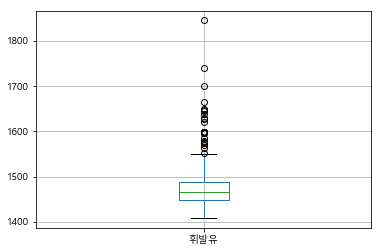

In [309]:
st_raw_price_exist.boxplot( column='휘발유' )

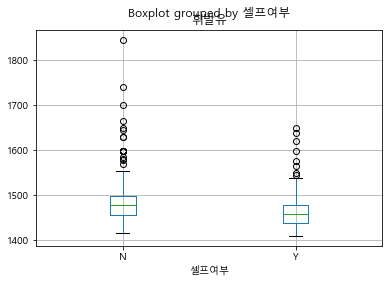

In [310]:
# 휘발유가 셀프냐 아니냐
st_raw_price_exist.boxplot( column='휘발유', by='셀프여부' )
# 셀프주유소가 일반 주유소대비 가격이 저렴하다 !!
# 모든 주유소가 싼것은 아니다. 일부 비싼 주유소도 존재

<function matplotlib.pyplot.show(*args, **kw)>

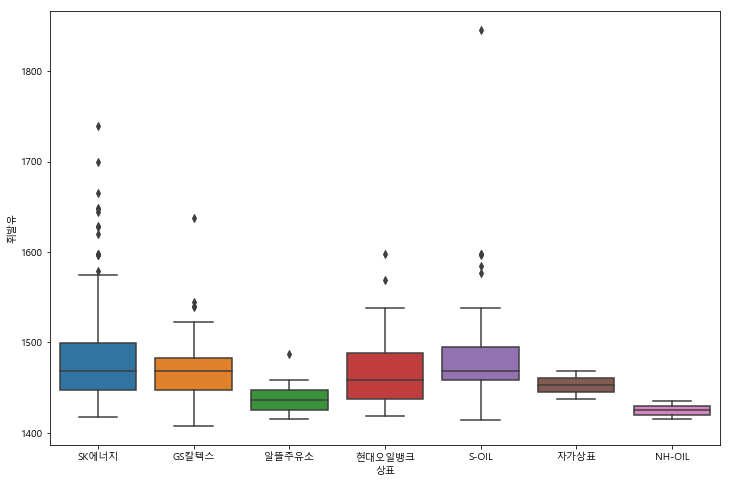

In [311]:
plt.figure( figsize=(12,8) )
sns.boxplot( x='상표', y='휘발유', data=st_raw_price_exist ) # seaborn이니깐 data지정해줘야한다
plt.show
# 부산 지역에서 알뜰 주유소가 브랜드 주유소 대비 싼가? NH를 제외하고는 평균적으로 싸다

<function matplotlib.pyplot.show(*args, **kw)>

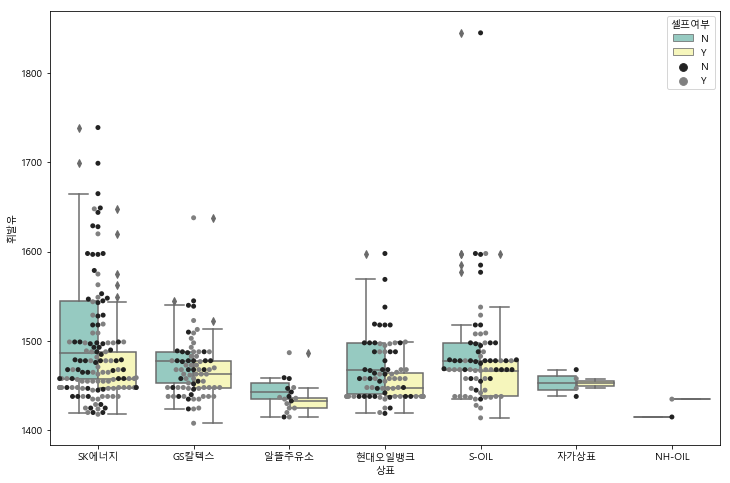

In [312]:
plt.figure( figsize=(12,8) )
sns.boxplot( x='상표', y='휘발유', hue='셀프여부', data=st_raw_price_exist, palette='Set3' ) # seaborn이니깐 data지정해줘야한다
sns.swarmplot( x='상표', y='휘발유', hue='셀프여부', data=st_raw_price_exist, color='.5' )

plt.show
# 셀프 주유소는 자가상표, NH를 제외하고 모든 비셀프보다 저렴(자사브랜드대비)
# NH는 그 주유소의 수량이 너무 작아서 사실상 배제
# 알뜰 주유소가 브랜드 대비 휘발유 가격이 싸다고주장할 수 있음

In [313]:
# 알뜰 주유소는 부산 전역 모든 주유소 대비 점유율 4.3%
len(st_raw_price_exist.loc[st_raw_price_exist['상표']=='알뜰주유소']) / len(st_raw_price_exist) * 100 
# 상표에서 알뜰주유소만 추출! -> loc을 통해 어떻게 표현되는지 한번 확인할 것

4.485488126649076

In [314]:
# 휘발유만 최소, 최대로 표현되게 처리
min_max_df = pd.pivot_table( st_raw_price_exist,
                             index='자치구',
                             values='휘발유',
                             aggfunc=[np.min, np.max])
min_max_df.head(2)

,amin,amax
,휘발유,휘발유
자치구,,
강서구,1415,1543
금정구,1438,1665


In [315]:
min_max_df.columns

MultiIndex(levels=[['amin', 'amax'], ['휘발유']],
           labels=[[0, 1], [0, 0]])

In [316]:
min_max_df['amin']

,휘발유
자치구,
강서구,1415
금정구,1438
기장군,1435
남구,1419
동구,1438
동래구,1436
부산진구,1425
북구,1425
사상구,1414


In [317]:
# 최소값만 -> 숫자만 나오게 조정
# 컬럼의 뎁스가 1이 이상인 경우 한개로 통합할 것인가?(1차로 갈것인가)
# 뎁스를 유지하면서 레벨로 접근하면서 갈것인가? -> 현재 소스코드는 유지하면서 진행하는것이다
for oil_price in min_max_df['amin']['휘발유']:
    print( oil_price )

1415
1438
1435
1419
1438
1436
1425
1425
1414
1430
1438
1437
1437
1497
1408


In [318]:
# 자치구, 가격 -> 같이 표현하고 싶을 경우 -> 자치구의 인덱스번호가 필요하다
# enumerate로 인덱스를 추출한다
for idx, oil_price in enumerate( min_max_df['amin']['휘발유']):
    print( min_max_df.index[idx], oil_price )

강서구 1415
금정구 1438
기장군 1435
남구 1419
동구 1438
동래구 1436
부산진구 1425
북구 1425
사상구 1414
사하구 1430
서구 1438
수영구 1437
연제구 1437
영도구 1497
중구 1408


In [319]:
# 대상변수는 st_raw_price_exist
# 각 자치구를 돌면서 저 가격에 해당되는 주유소를 찾아서, 상호, 주소를 추출!!
# 그래야지 => gas 획득 => 지도에 마킹이 가능

for idx, oil_price in enumerate( min_max_df['amin']['휘발유'] ):
    print(type(min_max_df.index[idx]), oil_price )
   # 1. 검색대상을 줄이고 -> 2. 그중에서 단가와 일치하는 대상을 찾는 방식 
    gu = st_raw_price_exist[ st_raw_price_exist['자치구']==min_max_df.index[idx] ]
    row = gu[ gu['휘발유']==oil_price ]
    print( row.shape, min_max_df.index[idx], oil_price )
    
##=> 위의 소스 코드 줄이기
    # 조건 2개를 [ () & () ]로 구현하여 대상을 좁혔다
    # 뭐가 되었던 전체를 계속 불리언 인덱싱을 해야 하므로, 조금 비효율적
    #row = st_raw_price_exist[ (st_raw_price_exist['자치구']==min_max_df.index[idx]) & (st_raw_price_exist['휘발유']==oil_price)]
    #print( row.shape, min_max_df.index[idx], oil_price)

<class 'str'> 1415
(1, 11) 강서구 1415
<class 'str'> 1438
(3, 11) 금정구 1438
<class 'str'> 1435
(8, 11) 기장군 1435
<class 'str'> 1419
(1, 11) 남구 1419
<class 'str'> 1438
(1, 11) 동구 1438
<class 'str'> 1436
(1, 11) 동래구 1436
<class 'str'> 1425
(1, 11) 부산진구 1425
<class 'str'> 1425
(1, 11) 북구 1425
<class 'str'> 1414
(1, 11) 사상구 1414
<class 'str'> 1430
(1, 11) 사하구 1430
<class 'str'> 1438
(1, 11) 서구 1438
<class 'str'> 1437
(1, 11) 수영구 1437
<class 'str'> 1437
(1, 11) 연제구 1437
<class 'str'> 1497
(2, 11) 영도구 1497
<class 'str'> 1408
(1, 11) 중구 1408


In [320]:
tmp = list()
for idx, oil_price in enumerate( min_max_df['amin']['휘발유'] ):
    # print(type(min_max_df.index[idx]), oil_price )
    gu = st_raw_price_exist[ st_raw_price_exist['자치구']==min_max_df.index[idx] ]
    row = gu[ gu['휘발유']==oil_price ]
    # print( row.shape, min_max_df.index[idx], oil_price )
    tmp.append( row )
    # 한덩어리로 만들어서 
    
# 출력
pd.concat( tmp ).shape

(25, 11)

In [321]:
# 리스트 내포로 처리
pd.concat( [
    st_raw_price_exist[ (st_raw_price_exist['자치구']==min_max_df.index[idx]) & (st_raw_price_exist['휘발유']==oil_price)]
    for idx, oil_price in enumerate( min_max_df['amin']['휘발유'] )
] ).head(1)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
331,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1415,1265,950,강서구


In [322]:
# col => 'amin', 'amax'
#1. for col in min_max_df.columns.levels[0]:  
#    pd.concat( [
#        st_raw_price_exist[ (st_raw_price_exist['자치구']==min_max_df.index[idx]) & (st_raw_price_exist['휘발유']==oil_price)]
#        for idx, oil_price in enumerate( min_max_df[col]['휘발유'] )
#    ] )
# 2.
tmp = list()
for col in min_max_df.columns.levels[0]:  
    tmp.append( pd.concat( [
        st_raw_price_exist[ (st_raw_price_exist['자치구']==min_max_df.index[idx]) & (st_raw_price_exist['휘발유']==oil_price)]
        for idx, oil_price in enumerate( min_max_df[col]['휘발유'] )
    ] ) )
pd.concat( tmp ).shape

(42, 11)

In [323]:
# 여기에 있는 1번 소스코드는 위의 2번 소스코드를 풀어서 쓴 것이다.( 결국 위의 2번 소스코드와 여기있는 1번 소스코드는 똑같은 것이다 )

# min, max를 각각 concat으로 구해서 다시 전체 2덩어리는 concat 시킨다
# 1. pd.concat([
#    pd.concat( [
#        st_raw_price_exist[ (st_raw_price_exist['자치구']==min_max_df.index[idx]) & (st_raw_price_exist['휘발유']==oil_price)]
#        for idx, oil_price in enumerate( min_max_df[col]['휘발유'] )
#    ] )
#    for col in min_max_df.columns.levels[0]
#]).shape

# 2.
target_df = pd.concat([
    pd.concat( [
        st_raw_price_exist[ (st_raw_price_exist['자치구']==min_max_df.index[idx]) & (st_raw_price_exist['휘발유']==oil_price)]
        for idx, oil_price in enumerate( min_max_df[col]['휘발유'] )
    ] )
    for col in min_max_df.columns.levels[0]
])
target_df.shape

(42, 11)

In [324]:
# 대상 주유소에 대한 df는 target_df에 모여있다
# 하나씩 빼서, gps를 완선(api를 사용)후 지도에 시각화
# 비싼 주유소는 빨강색, 싼 주유소는 파랑색 표시
# gps는 주소를 통해서 획득
target_df.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

In [325]:
len(target_df.index), len(target_df.index.unique())

(42, 42)

In [326]:
target_df.index

Int64Index([331,   0,   1,   2,  84,  85,  86,  87,  88,  89,  90,  91, 130,
            165, 175, 199, 223, 242, 298,  24,  36,  53,  70,  71,  82, 378,
             23, 129, 162, 163, 164, 174, 198, 222, 241, 297, 330,  35,  52,
             69,  81,  83],
           dtype='int64')

In [327]:
# 카카오 api 
import urllib, json
API_KEY = 'e34bb81e2e35e85ca6efee410badd670'
# search/ 뒤에 address로 받는다.(devkakao api 참조)https://developers.kakao.com/docs/restapi/local#%EC%A3%BC%EC%86%8C-%EA%B2%80%EC%83%89
url     = 'https://dapi.kakao.com/v2/local/search/address.json?query={}' 
def getGpsByAddr( addr ):
    try: # 예외처리
        tmp_url = url.format( urllib.parse.quote(addr) )
        request = urllib.request.Request( tmp_url )
        request.add_header("Authorization", 'KakaoAK {app_key}'.format(app_key=API_KEY) )
        response = urllib.request.urlopen(request)
        if(response.getcode()==200):
            tmp = json.load(response)
            y = tmp['documents'][0]['y']  
            x = tmp['documents'][0]['x']
            return y, x
        else:
            return 0, 0 # 적도 좌표로 보낸다
    except Exception as e:
        print('오류', addr)
        return 0,0

In [328]:
# 앞뒤 공백을 모두 제거하고 싶다면 : .apply( lambda x: x.strip() )
# 제거후 주소를 하나씩 뽑는다
lats = list()
lngs = list()
for addr in target_df['주소'].apply( lambda x: x.strip() ):
    print(addr)
    # 통신 후 gps를 획득 ( 통신 소스코드는 위에 있는 소스코드를 참조함 )
    lat, lng = getGpsByAddr( addr ) # getGpsByAddr: return타입(튜플): 리턴을 2개하라는 의미이다
    lats.append(lat)
    lngs.append(lng)

부산 강서구 낙동남로 448 (녹산동)
부산 금정구 중앙대로 1972
부산 금정구 중앙대로 2191 (노포동)
부산 금정구 두실로 2 (남산동)
부산 기장군 일광면 기장대로 1291
부산 기장군 정관면 정관로 901
부산광역시 기장군 장안읍 좌동길 47
부산 기장군 일광면 기장대로 1037
부산 기장군 일광면 기장대로 1230
부산 기장군 장안읍 좌동길 45
부산 기장군 장안읍 정관로 1115
부산 기장군 기장읍 기장대로 84
부산 남구 신선로 252
부산 동구 중앙대로 352 (초량동)
부산 동래구 충렬대로 124 (온천동)
부산 부산진구 백양대로 231
부산 북구 백양대로 995 (구포동)
부산 사상구 새벽로 154 (감전동)
부산광역시 사하구  장평로 152 (장림동)
부산 서구 보수대로 220
부산 수영구 연수로 250 (망미동)
부산 연제구 고분로 51 (연산동)
부산 영도구 태종로 782 (동삼동)
부산 영도구 태종로 806-1 (동삼동)
부산광역시 중구  중구로 194 (영주동)
부산 강서구 낙동북로 42 (강동동)
부산 금정구 중앙대로 1756
부산 기장군 정관면 정관덕산길 21
부산 남구 석포로 134 (대연동)
부산 남구 황령대로98번길 75 (문현동)
오류 부산 남구 황령대로98번길 75 (문현동)
부산 남구 유엔로 42 (우암동)
부산 동구 중앙대로 168 (초량동)
부산 동래구 중앙대로 1371 (온천동)
부산 부산진구 전포대로176번길 5 (전포동)
오류 부산 부산진구 전포대로176번길 5 (전포동)
부산 북구 금곡대로 362 (화명동)
부산 사상구 낙동대로 1274 (삼락동)
부산 사하구 장림번영로 7 (장림동)
부산 서구 대신공원로 1 (동대신동3가)
부산 수영구 좌수영로 147 (망미동)
부산 연제구 아시아드대로 107 (거제동)
부산 영도구 태종로 181 (봉래동4가)
부산 중구 대청로 153 (중앙동5가)


In [329]:
target_df['위도'] = lats
target_df['경도'] = lngs

In [330]:
target_df.head(2).

SyntaxError: invalid syntax (<ipython-input-330-c42ccffddb5e>, line 1)

In [331]:
# gps를 획득하지 못한 2개 데이터를 제거후(결측치 처리) -> 마킹의 최종 데이터
target_df = target_df[ target_df['위도']!=0 ]
target_df.shape

(40, 13)

In [332]:
# 최저가들 중에서 최고값
min_max_df['amin']['휘발유'].max()
# 마킹시 휘발유 값이 1497 >=(작거나 같으면)이면 마킹의 칼라를 blue

1497

In [333]:
# 최고가들 중에서 최저값
min_max_df['amax']['휘발유'].min()
# 마킹시 휘발유 값이 1518 <=(크거나 같으면)이면 마킹의 칼라를 red

1518

In [334]:
tmp = pd.DataFrame( x_scaled, columns=['휘발유정규화'], index=st_raw_gasoline.index)
map_busan = folium.Map( location=gps, zoom_start=10 )
folium.Choropleth( geo_data = geo_str
                 , name='busan'
                 , data=tmp
                 , columns=[tmp.index, '휘발유정규화'] # tmp의 인덱스
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='부산시 자치구별 휘발유가격 비율'
                 ).add_to(map_busan)
    
for n in target_df.index:
    
    # 0. 순수한 표현
    #color = 'blue'
    #if target_df['휘발유'][n] >1497:
    #    color = 'red'
    
    # 파이썬의 삼항연산자 대용
    # 1. 조건 and 참일때 값 or 거짓일때 값 -> bt 연산 쓴거다
    # color = target_df['휘발유'][n] > 1497 and 'red' or 'blue'
    
    # 2. 참일때값 if 조건 else 거짓일때값 -> 조건문 쓴거다
    color = 'red' if target_df['휘발유'][n] > 1497 else 'blue' # and 쓰는게 어려울 경우 
    folium.Marker( [target_df['위도'][n], target_df['경도'][n]], 
                   popup='%s/%s' % (target_df['휘발유'][n], target_df['상호'][n]), 
                   icon=folium.Icon(icon='cloud', color=color) ).add_to(map_busan)

map_busan

In [ ]:
# 테스트 마이닝 쪽으로 넘어간다